**CONFIRM CASES**


In [ ]:
pip install helper

Importing important libraries

In [2]:
%matplotlib inline

import sys
sys.path.append("../")
import copy
import itertools
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import helper
import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import files
uploaded = files.upload()

Saving covid_19_clean_complete.csv to covid_19_clean_complete.csv


**Reading the Dataset**

In [5]:
dataframe=pd.read_csv('/content/covid_19_clean_complete.csv', parse_dates=['Date'])
dataframe['Province/State']=dataframe['Province/State'].fillna('')
dataframe.rename(columns={'Country/Region':'Country','Province/State':'State'},inplace=True)
dataframe

State                Country        Lat  ...  Confirmed Deaths  Recovered
0                      Afghanistan  33.000000  ...          0      0          0
1                          Albania  41.153300  ...          0      0          0
2                          Algeria  28.033900  ...          0      0          0
3                          Andorra  42.506300  ...          0      0          0
4                           Angola -11.202700  ...          0      0          0
...     ...                    ...        ...  ...        ...    ...        ...
32060        Sao Tome and Principe   0.186360  ...        251      8          4
32061                        Yemen  15.552727  ...        197     33          0
32062                      Comoros -11.645500  ...         34      1          8
32063                   Tajikistan  38.861034  ...       2350     44          0
32064                      Lesotho -29.609988  ...          1      0          0

[32065 rows x 8 columns]

In [6]:
queried =dataframe.query('Country=="Belgium"')   #We are extracting the columns in which we are interested.
df=queried.fillna('').groupby(['Date'])['Confirmed'].max()
df=pd.DataFrame(df)
df

Confirmed
Date                 
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
...               ...
2020-05-17      55280
2020-05-18      55559
2020-05-19      55791
2020-05-20      55983
2020-05-21      56235

[121 rows x 1 columns]

**Spliting the Dataset**


In [24]:
train=df[0:97]
test=df[97:]
test

Confirmed
Date                 
2020-04-28      47334
2020-04-29      47859
2020-04-30      48519
2020-05-01      49032
2020-05-02      49517
2020-05-03      49906
2020-05-04      50267
2020-05-05      50509
2020-05-06      50781
2020-05-07      51420
2020-05-08      52011
2020-05-09      52596
2020-05-10      53081
2020-05-11      53449
2020-05-12      53779
2020-05-13      53981
2020-05-14      54288
2020-05-15      54644
2020-05-16      54989
2020-05-17      55280
2020-05-18      55559
2020-05-19      55791
2020-05-20      55983
2020-05-21      56235

In [64]:
# Series to test
column_name = df.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Confirmed cases will be used for the analysis


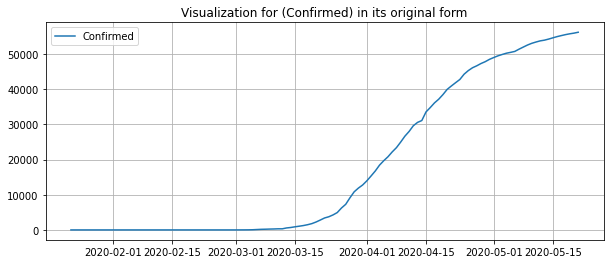

In [8]:
plt.figure(figsize=(10,4))
plt.plot(df, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %df.columns[0])
plt.grid()
plt.show()

In [9]:
df.tail()

Confirmed
Date                 
2020-05-17      55280
2020-05-18      55559
2020-05-19      55791
2020-05-20      55983
2020-05-21      56235

In [10]:
df_to_test = copy.deepcopy(df)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [11]:
df_to_test.tail()

Confirmed
Date                 
2020-05-17      55280
2020-05-18      55559
2020-05-19      55791
2020-05-20      55983
2020-05-21      56235

In [14]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [15]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [16]:
#Mean absolute percentage error (MAPE) 

def mape(actual, predicted): 
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [17]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [26]:
#Finding the best parameters 
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [27]:
print(column_name)
results = grid_search(df_to_test)

Confirmed
([(0, 0, 0), (0, 0, 0, 365), 'n'], 28195.577480716267, 18146.661157024795)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 28195.577480716267, 18146.661157024795)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 21516.68608043449, 19512.660064203264)
([(0, 0, 0), (0, 0, 0, 365), 't'], 11784.737516512534, 10494.26508623891)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 8593.77676230721, 7506.482508424193)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 14213.251894564455, 9183.618486485873)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 27219.97516255703, 18973.885477924126)
([(0, 0, 1), (0, 0, 0, 365), 't'], 20496.16766859943, 18440.31949425574)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 8714.969253553545, 7687.002947110728)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 7594.32248236621, 4862.217333036092)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 8908.42960927424, 6995.477478910009)
([(0, 0, 2), (0, 0, 0, 365), 't'], 3285.548631290017, 2848.6646057704124)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 5086.625322057948, 4275.29397729934)
([(0, 1, 0), (0, 0, 0, 365), 'n']

In [28]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]
print(column_name)
print(best_combination, best_error, mae)

Confirmed
[(2, 0, 1), (0, 0, 0, 365), 't'] 236.57290215758294 142.27288802846283


In [29]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

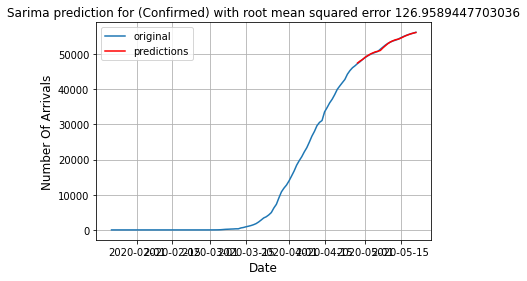

In [30]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(test, predictions)
#errors=mape(df_to_test,predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name,error))
#plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name,errors))
plt.show()

In [31]:
errors = mape(test, predictions)
errors

5.958981169537592

In [ ]:
#Recovered Cases in Belgium'''

RECOVERED CASES

In [32]:
q=dataframe.query('Country=="Belgium"')
dfr=q.fillna('').groupby(['Date'])['Recovered'].max()
dfr=pd.DataFrame(dfr)
dfr

Recovered
Date                 
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
...               ...
2020-05-17      14630
2020-05-18      14657
2020-05-19      14687
2020-05-20      14847
2020-05-21      14988

[121 rows x 1 columns]

In [33]:
trainr=dfr[0:97]
testr=dfr[97:]
len(testr)

24

In [66]:
# Series to test
column_name = dfr.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Recovered  cases will be used for the analysis


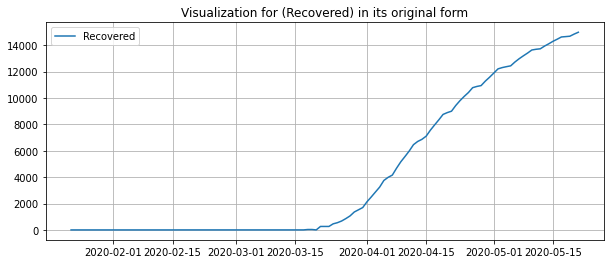

In [35]:
plt.figure(figsize=(10,4))
plt.plot(dfr, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %dfr.columns[0])
plt.grid()
plt.show()

In [36]:
dfr.tail()

Recovered
Date                 
2020-05-17      14630
2020-05-18      14657
2020-05-19      14687
2020-05-20      14847
2020-05-21      14988

In [37]:
df_to_test = copy.deepcopy(dfr)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [38]:
df_to_test.tail()

Recovered
Date                 
2020-05-17      14630
2020-05-18      14657
2020-05-19      14687
2020-05-20      14847
2020-05-21      14988

In [39]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [40]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [41]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [42]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [43]:
print(column_name)
results = grid_search(df_to_test)

Recovered
([(0, 0, 0), (0, 0, 0, 365), 'n'], 6875.001869270971, 4225.264462809917)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 6875.001869270971, 4225.264462809917)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 5409.736280641306, 4818.590601734854)
([(0, 0, 0), (0, 0, 0, 365), 't'], 3188.416320156544, 2811.7774802961653)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 2399.9216374587527, 2102.358245556707)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 3494.2853458039194, 2157.2714759582163)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 5441.420131426943, 4853.1272937458525)
([(0, 0, 1), (0, 0, 0, 365), 't'], 1616.4130993881881, 1429.4344325572563)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 1267.8839873983752, 1082.9905780178792)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 1815.1808518948096, 1119.1847569286685)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 1549.950959534968, 1344.5880836774572)
([(0, 0, 2), (0, 0, 0, 365), 't'], 940.4989691018038, 806.4304532127853)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 783.2504580403862, 619.6817074357405)
([(0, 1, 0), (0, 0, 0, 365

In [44]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Recovered
[(2, 0, 2), (0, 0, 0, 365), 't'] 82.02359242888781 54.03730499593326


In [45]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

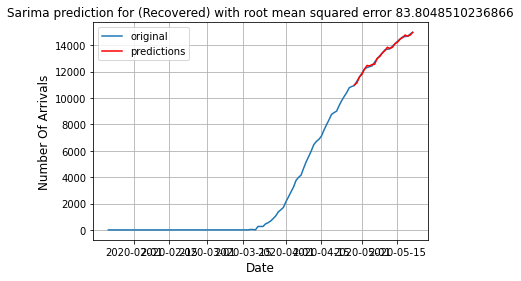

In [46]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(testr, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [47]:
mape(testr, predictions)

10.365895612727284

In [ ]:
# Deaths cases

**DEATH CASES**

In [48]:
q=dataframe.query('Country=="Belgium"')
dfd=q.fillna('').groupby(['Date'])['Deaths'].max()
dfd=pd.DataFrame(dfd)
dfd

Deaths
Date              
2020-01-22       0
2020-01-23       0
2020-01-24       0
2020-01-25       0
2020-01-26       0
...            ...
2020-05-17    9052
2020-05-18    9080
2020-05-19    9108
2020-05-20    9150
2020-05-21    9186

[121 rows x 1 columns]

In [65]:
# Seriies to test
column_name = dfd.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Deaths cases will be used for the analysis


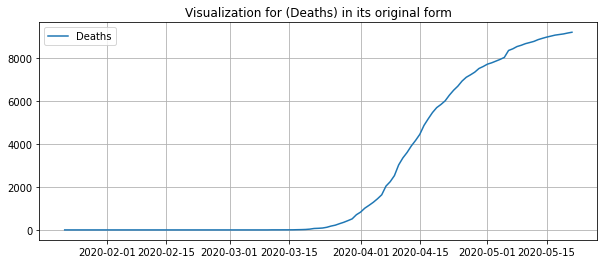

In [50]:
plt.figure(figsize=(10,4))
plt.plot(dfd, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %dfd.columns[0])
plt.grid()
plt.show()

In [51]:
dfd.tail()

Deaths
Date              
2020-05-17    9052
2020-05-18    9080
2020-05-19    9108
2020-05-20    9150
2020-05-21    9186

In [52]:
traind=dfd[0:97]
testd=dfd[97:]
testd

Deaths
Date              
2020-04-28    7331
2020-04-29    7501
2020-04-30    7594
2020-05-01    7703
2020-05-02    7765
2020-05-03    7844
2020-05-04    7924
2020-05-05    8016
2020-05-06    8339
2020-05-07    8415
2020-05-08    8521
2020-05-09    8581
2020-05-10    8656
2020-05-11    8707
2020-05-12    8761
2020-05-13    8843
2020-05-14    8903
2020-05-15    8959
2020-05-16    9005
2020-05-17    9052
2020-05-18    9080
2020-05-19    9108
2020-05-20    9150
2020-05-21    9186

In [53]:
df_to_test = copy.deepcopy(dfd)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [54]:
df_to_test.tail()

Deaths
Date              
2020-05-17    9052
2020-05-18    9080
2020-05-19    9108
2020-05-20    9150
2020-05-21    9186

In [55]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [56]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [57]:
#Generate all possible combinations of hyperparameters
  
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [58]:
#Finding the best parameters
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [59]:
print(column_name)
results = grid_search(df_to_test)

Deaths
([(0, 0, 0), (0, 0, 0, 365), 'n'], 4354.357189894978, 2614.2727272727275)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 4354.357189894978, 2614.2727272727275)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 3474.121733484556, 3106.3373403456044)
([(0, 0, 0), (0, 0, 0, 365), 't'], 2128.748289201277, 1902.9538016571269)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 1645.073044260052, 1458.2876610755745)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 2217.50146588151, 1338.0199360286867)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 3815.518050864518, 2786.1620740567305)
([(0, 0, 1), (0, 0, 0, 365), 't'], 1078.0270308256083, 966.3211211975101)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 867.0642760657329, 753.1121990340474)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 1140.3847815355778, 686.4171686164814)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 967.9853815388165, 853.3857490501199)
([(0, 0, 2), (0, 0, 0, 365), 't'], 991.4954929297364, 796.1387127439395)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 924.4177276391035, 801.121367179468)
([(0, 1, 0), (0, 0, 0, 365), 'n'],

In [60]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Deaths
[(2, 0, 1), (0, 0, 0, 365), 'ct'] 48.337976774364506 27.325034954742648


In [61]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

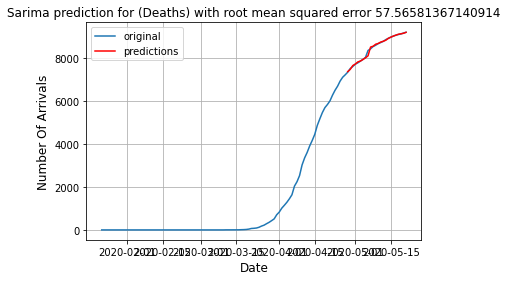

In [62]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(testd, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [63]:
mape(testd,predictions)

7.915622908245655